Fill in the missing code (#####). Here you learn to use the pearson_loss function, the penalized_pearson_loss function and the pearson_metric function. See important comment at the end.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import numpy as np
# from keras.layers import Dense
# from keras.models import Sequential
# from keras.optimizers import SGD
from matplotlib import pyplot
from scipy.stats import spearmanr
from scipy.stats import pearsonr
# import keras.backend as K
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
# import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.backend as K

In [2]:
def pearson_loss(y_true, y_pred):
    """Pearson correlation coefficient"""

    x = y_true
    y = y_pred
    xm, ym = x - K.mean(x), y - K.mean(y)
    r_num = K.sum(tf.multiply(xm, ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / (r_den + K.epsilon())
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    
    return  tf.constant(1.0, dtype=x.dtype) - K.square(r)

penalized_pearson_loss is a function that maximizes the pearson correlation coefficient between the predicted values and the labels, while trying to have the same mean and variance.  It is the same as pearson_loss except for the addition of a penalty term (0.01*sqdif):https://archive.md/k5aTF

In [3]:
def penalized_pearson_loss(x,y, axis=-2):
    """Penalized Pearson correlation coefficient"""
    x = tf.convert_to_tensor(x)
    y = K.cast(y, x.dtype)
    n = tf.cast(tf.shape(x)[axis], x.dtype)
    xsum = tf.reduce_sum(x, axis=axis)
    ysum = tf.reduce_sum(y, axis=axis)
    xmean = xsum / n
    ymean = ysum / n
    xsqsum = tf.reduce_sum( tf.math.squared_difference(x, xmean), axis=axis)
    ysqsum = tf.reduce_sum( tf.math.squared_difference(y, ymean), axis=axis)
    cov = tf.reduce_sum( (x - xmean) * (y - ymean), axis=axis)
    corr = cov / (tf.sqrt(xsqsum * ysqsum)+ K.epsilon())
    sqdif = tf.reduce_sum(tf.math.squared_difference(x, y), axis=axis) / n / tf.sqrt(ysqsum / n)
    return tf.convert_to_tensor( K.mean(tf.constant(1.0, dtype=x.dtype) - corr + (0.01 * sqdif)) , dtype=tf.float32 )

In [4]:
def pearson_metric(y_true, y_pred):
    """Pearson correlation coefficient"""

    x = y_true
    y = y_pred
    xm, ym = x - K.mean(x), y - K.mean(y)
    r_num = K.sum(tf.multiply(xm, ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / (r_den + K.epsilon())
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    
    return tf.constant(1.0, dtype=x.dtype) - K.square(r)

In [5]:
num_features = 20
# generate regression dataset
X, y = make_regression(n_samples=1000, n_features=num_features, noise=0.1, random_state=1)

# split into train and test
n_train = 500
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# reshape 1d arrays to 2d arrays
trainy = trainy.reshape(len(trainy), 1)
testy = testy.reshape(len(trainy), 1)

# create scaler
scaler = StandardScaler()
# fit scaler on training dataset
scaler.fit(trainy)
# transform training dataset
trainy = scaler.transform(trainy)
# transform test dataset
testy = scaler.transform(testy)

# fit scaler on training dataset
scaler.fit(trainX)
# transform training dataset
trainX = scaler.transform(trainX)
# transform test dataset
testX = scaler.transform(testX)

In [6]:
# mlp with scaled inputs outputs on the regression problem using custom loss and custom metric
# define model
model = Sequential()
model.add(Dense(25, input_dim=20, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear'))
# compile model using as loss: penalized_pearson_loss; as metric: pearson_metric AND kears.losses.mean_squared_error
#model.compile(#####


# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=1)
# evaluate the model
train_e = model.evaluate(trainX, trainy, verbose=1)
test_e = model.evaluate(testX, testy, verbose=1)
print('Train loss: %.3f, Test loss: %.3f' % (train_e[0], test_e[0])) #when using custom loss and custom metric
print('Train metric: %.3f, Test metric: %.3f' % (train_e[1], test_e[1])) #when using custom loss and custom metric
#print('Train loss: %.3f, Test loss: %.3f' % (train_e, test_e)) 
#plot loss during training
plt.title('Loss / Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

/Users/stevey/cpsc330arm/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-07-09 17:53:10.880004: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-07-09 17:53:10.880188: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-07-09 17:53:10.880199: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-07-09 17:53:10.880650: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-09 17:53:10.880665: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created Te

ValueError: You must call `compile()` before using the model.

In [7]:
df = pd.DataFrame(history.history)
df.head(3)

,val_loss,val_pearson_metric,val_mean_squared_error,loss,pearson_metric,mean_squared_error
0,0.287630,0.472601,0.774692,0.604974,0.768632,1.043678
1,0.124955,0.224412,0.711608,0.228364,0.385809,0.699893
2,0.083836,0.151744,0.782079,0.105226,0.190619,0.659500


<AxesSubplot:>

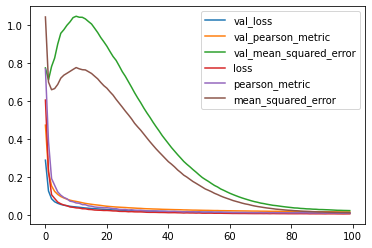

In [8]:
df.plot()

Penalized_pearson_loss has the advantage that it is easy to interpret, unlike MSE or a negative value of R-squared (which can arise in a non-linear model). But it has a disadvantage: When penalized_pearson_loss is used as loss (as it is used here), it minimizes both direction differences and distance differences.  But it does so at different rates: it minimizes direction differences quickly and distance differences more slowly. This is why, when using the penalized_pearson_loss, the mse_metric converges more slowly. But the important thing is that it (MSE, distance) eventually converges after about 70 epochs.

For non-linear models you can use loss: MSE ('mean_squared_error'), and metric: pearson_metric. You can also experiment with loss: penalized_pearson_loss, and metric: kears.losses.mean_squared_error, making sure that convergence is happening. 